In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano
import xarray as xr
from scipy.spatial import distance_matrix
from scipy.linalg import block_diag
from scipy.stats import multivariate_normal, norm

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.style as style
from tqdm import tqdm 
tqdm.pandas()
plt.rcParams.update({'axes.labelsize':16})
plt.rcParams.update({'axes.titlesize':16})
plt.rcParams.update({'legend.fontsize':16})
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 4
style.use('ggplot')
import os
os.chdir('../')
from python_code import basic_gibbs
os.chdir('notebooks')
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

In [25]:
pca = PCA(n_components=2)
df = pd.read_csv('../data/all_data.csv')
df = df.drop(columns='transit_stations_percent_change_from_baseline')
df = df.dropna()
X_transformed = pca.fit_transform(df[df.columns[1:6]])
df['component_1'] = X_transformed[:,0]
df['component_2'] = X_transformed[:,1]
df['intercept'] = 1
df['time'] =  pd.to_datetime(df['date']).dt.day_of_year

In [4]:
X_depts, y_depts = [], []
time_vecs = []
date_vecs = []
grouped_df =  df.groupby('department_name')
groups = grouped_df.groups.keys()
for n, dept in enumerate(groups):
    df_dept = grouped_df.get_group(dept)
    df_dept = df_dept.sort_values('date')
    date_vecs.append(df_dept['date'])
    X = df_dept[['intercept','component_1','component_2']].to_numpy()
    y = df_dept['incidents'].to_numpy()
    X_depts.append(X)
    y_depts.append(y.flatten())
    df_dept['day_of_the_year'] = pd.to_datetime(df_dept['date']).dt.day_of_year
    time_vecs.append(df_dept['day_of_the_year'].to_numpy())

In [5]:
distance_mats = [distance_matrix(X.reshape(-1,1), X.reshape(-1,1)) for X in time_vecs]

$$
  y_i = N(X_i \beta_i ,  C_i + \sigma_i^2I)
$$



$$
  \beta_{ij} \sim N(\mu_j, \tau_j^2)
$$

In [168]:
X_depts[0].shape

(46, 3)

/var/folders/5t/ltqvfkd124z1n5v3ntgw77d40000gn/T/ipykernel_53095/2303950091.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


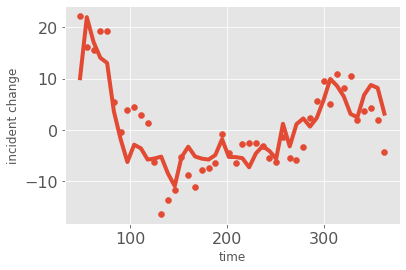

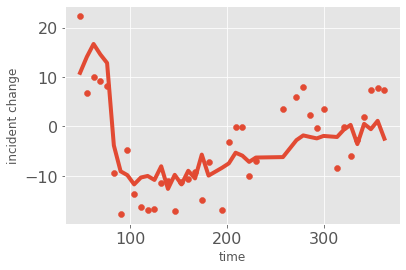

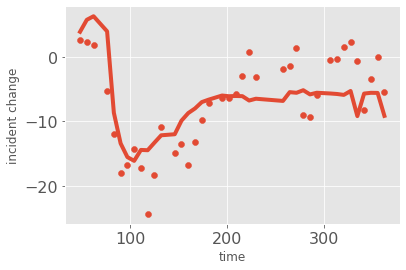

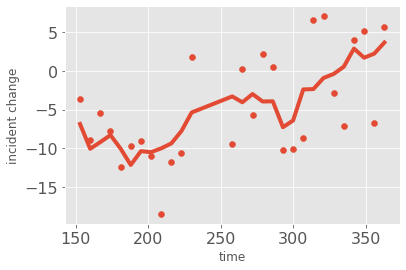

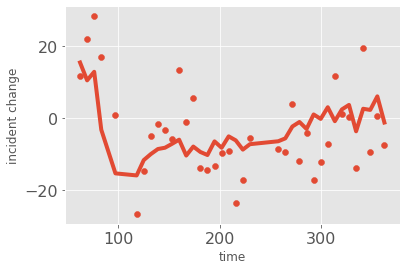

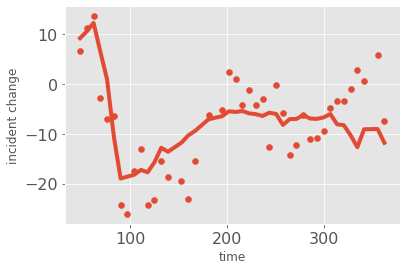

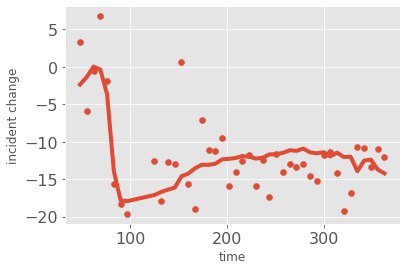

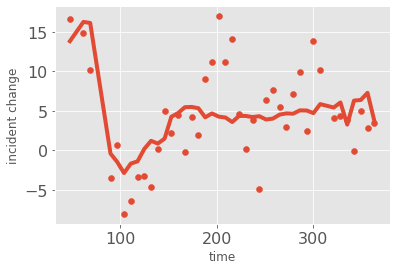

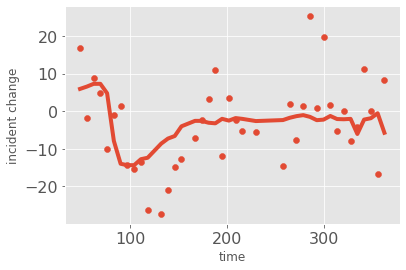

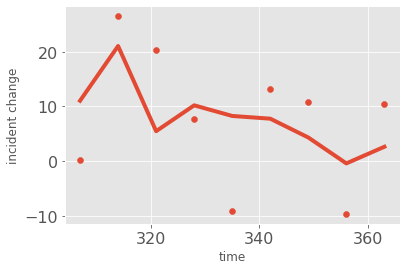

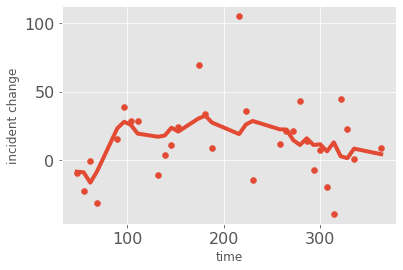

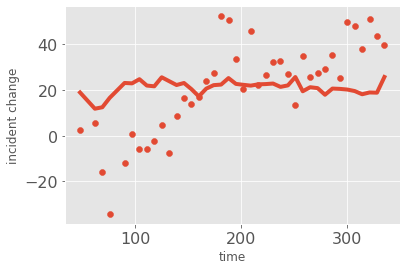

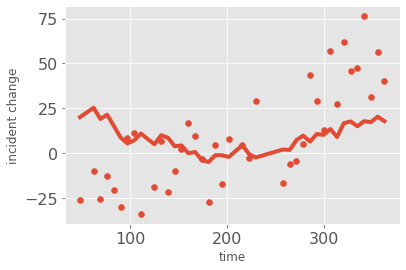

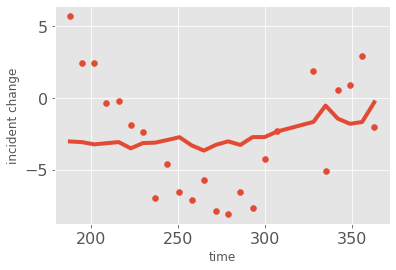

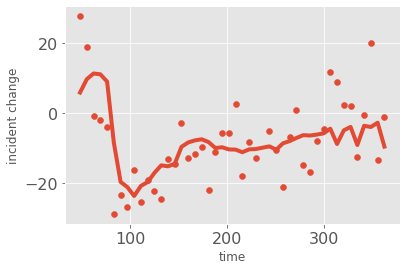

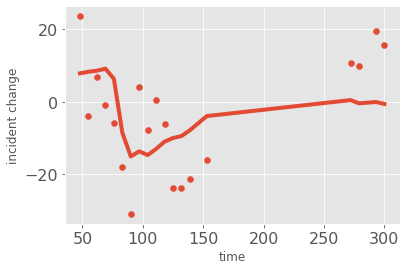

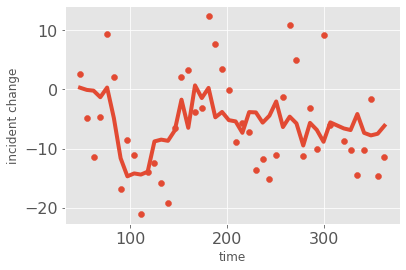

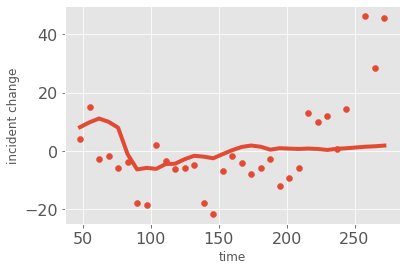

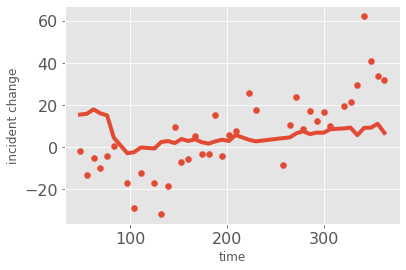

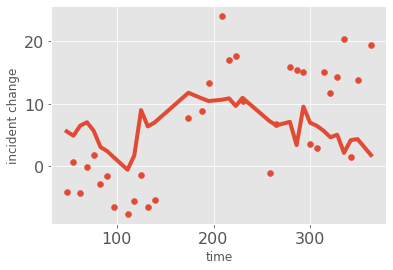

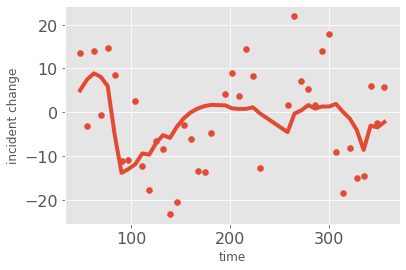

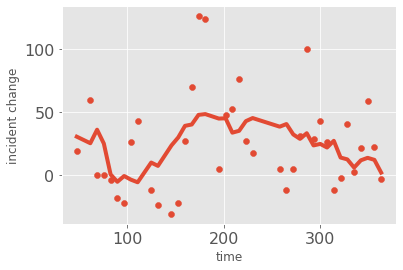

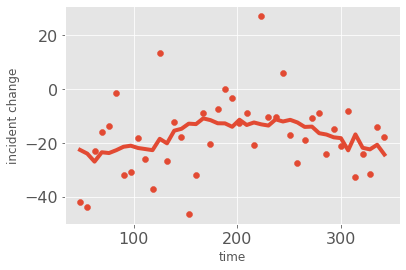

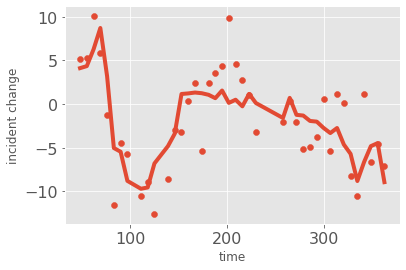

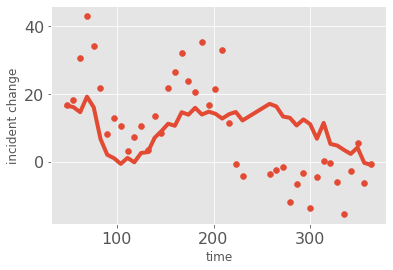

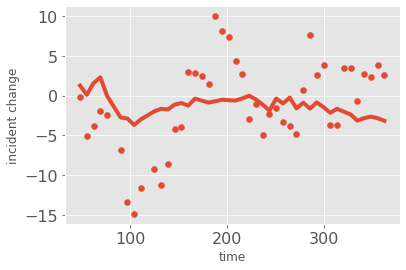

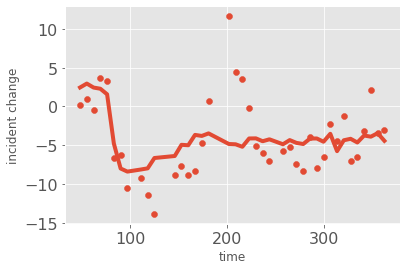

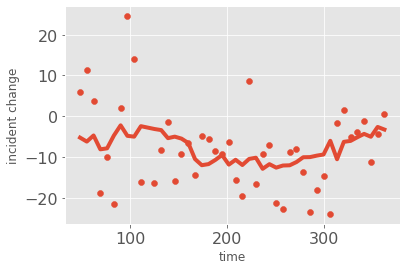

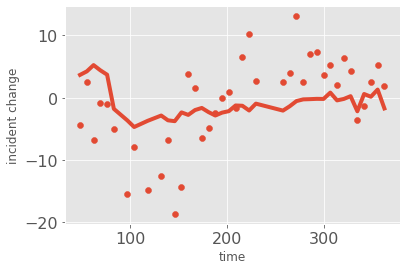

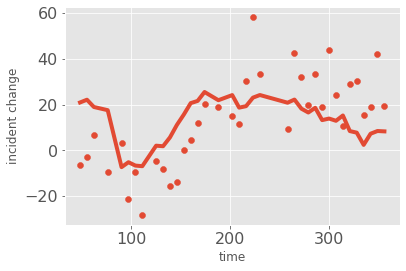

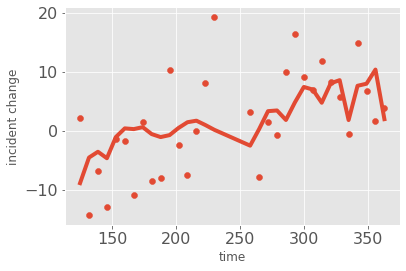

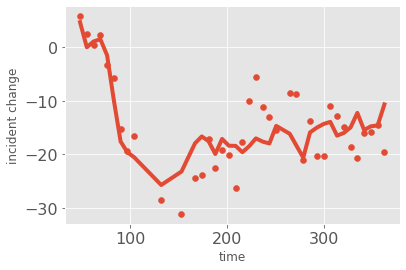

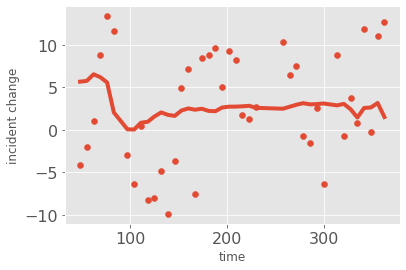

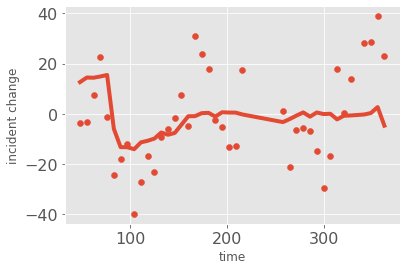

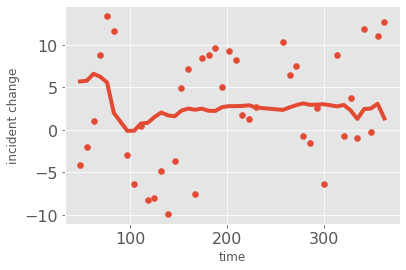

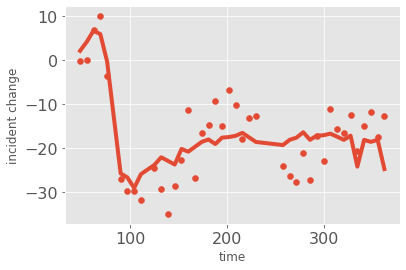

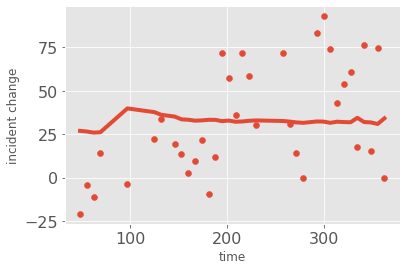

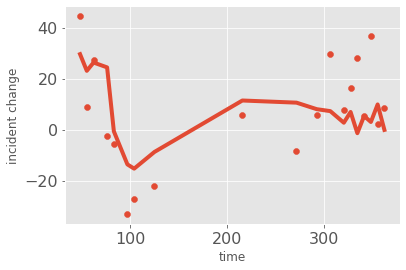

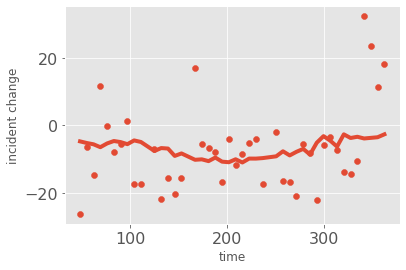

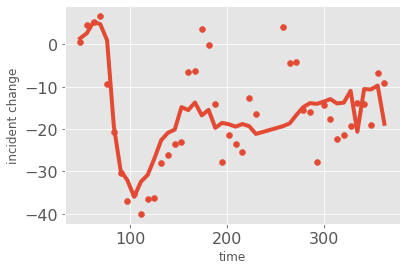

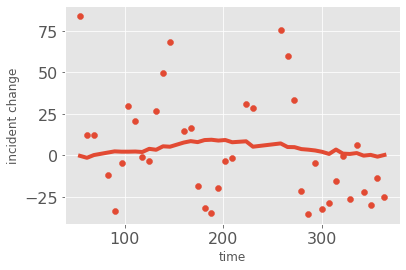

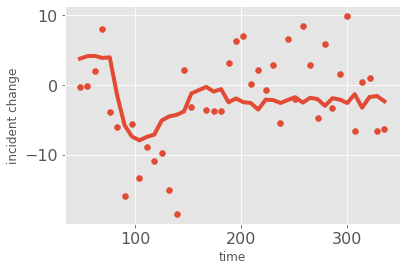

<Figure size 432x288 with 0 Axes>

In [169]:
for i in range(len(X_depts)):
    reg = LinearRegression()
    reg.fit(X_depts[i][:, 1:], y_depts[i])
    plt.scatter(time_vecs[i], y_depts[i])
    plt.plot(time_vecs[i], reg.predict(X_depts[i][:, 1:]))
    plt.xlabel('time')
    plt.ylabel('incident change')
    plt.figure()

In [6]:
mu_betas = [5, 0.1, 0.1]
std_betas = [1, 0.2, 0.2]

In [7]:
betas = norm(mu_betas, std_betas).rvs(size=(len(X_depts),3))
bandwidth = [150**2] * len(X_depts)
tau_sq = [20] * len(X_depts)
sigmas = [10] * len(X_depts)

In [8]:
def cov(bandwidth_sq, tau, distance):
    return tau * np.exp(-distance**2 / bandwidth_sq) + 1e-8 * np.eye(len(distance))

In [9]:
y = []
for i in range(len(X_depts)):
    y.append(multivariate_normal(X_depts[i]@betas[i], sigmas[i]*np.eye(distance_mats[i].shape[0]) + cov(bandwidth[i], tau_sq[i], distance_mats[i]), allow_singular=True).rvs())
    

In [10]:
np.random.seed(1)
plt.figure(figsize=(15,5))

reg = LinearRegression()
reg.fit(X_depts[0][:, 1:], y_1)
betas_0 = [reg.intercept_, *reg.coef_]
plt.plot(time_vecs[0], reg.predict(X_depts[0][:, 1:]), color='black')
#plt.plot(time_vecs[0], X_depts[0]@betas_0, color='blue')


#for b in np.linspace(10,100,10):
y_1 = multivariate_normal(mean=X_depts[0]@betas_0, cov=cov(100**2, 20, distance_mats[0])+ np.eye(distance_mats[0].shape[0]), allow_singular=True).rvs()
plt.scatter(time_vecs[0], y_1)
plt.figure()

plt.plot(reg.predict(X_depts[0][:, 1:]) - y_1)
   
    #y_2 = multivariate_normal(mean=X_depts[0]@betas[0], cov=cov(10, 1, distance_mats[0])+ 1*np.eye(distance_mats[0].shape[0])).rvs()
#plt.plot(time_vecs[0], y_2)
plt.figure()
plt.plot(reg.predict(X_depts[0][:, 1:]) - y_1)



#plt.plot(time_vecs[i], reg.predict(X_depts[i]))



NameError: name 'y_1' is not defined

<Figure size 1080x360 with 0 Axes>

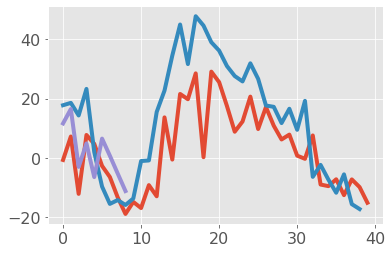

In [11]:
## plt.plot(y[0])
plt.plot(y[1])
plt.plot(y[2])
plt.plot(y[9])

In [12]:
with pm.Model() as model:
    # priors
    beta_0 = pm.Normal(f"beta_0", mu=0, sigma=20) 
    beta_1 = pm.Normal(f"beta_1", mu=0, sigma=20) 
    beta_2 = pm.Normal(f"beta_2", mu=0, sigma=20) 
    b = pm.TruncatedNormal("b", mu=100, sigma=200, lower=0)
    tau_s1 = pm.TruncatedNormal("tau_sq", mu=5, sigma=10, lower=0)
    noise_var = pm.TruncatedNormal('noise_var', mu=5, sigma=100, lower=0) 

    means = beta_0 + beta_1 * X_depts[n][:, 1] + beta_2 * X_depts[n][:, 2]
    K = tau_s1 * tt.exp(-distance_mats[n]**2 / b**2) + 1e-8 * tt.eye(len(distance_mats[n]))
    y_ = pm.MvNormal(f'y', mu=means, cov=K+noise_var*tt.eye(distance_mats[n].shape[0]), shape=len(y_depts[n]), observed=y_depts[n])

                        

NameError: name 'tt' is not defined

In [209]:
with model:
    step=pm.Metropolis()
    trace = pm.sample(5000, tune=500, chains=1)

/Users/juliette/opt/anaconda3/envs/reseach_env/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [noise_var, tau_sq, b, beta_2, beta_1, beta_0]


Sampling 1 chain for 500 tune and 5_000 draw iterations (500 + 5_000 draws total) took 21 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [26]:
df = df[df['department_name'].isin(np.unique(df['department_name'])[0:15])]


In [27]:
import theano.tensor as tt

dept_idxs, dept = pd.factorize(df.department_name)
coords = {
    "dept": dept,
    "obs_id": np.arange(len(dept_idxs)),
}

In [28]:
dist = distance_matrix(df['time'].to_numpy().reshape(-1,1), df['time'].to_numpy().reshape(-1,1))

$$
  y_i = N(X_i \beta_i ,  C_i + \sigma_i^2I)
$$



$$
  \beta_{ij} \sim N(\mu_j, \tau_j^2)
$$

In [29]:
n_depts = len(df.groupby('department_name').groups)

In [30]:
group_sizes = df.groupby('department_name').size().to_numpy()

In [31]:
mats = [np.ones([group_sizes[i], group_sizes[i]]) for i in range(len(group_sizes))]
boolean_block_mat =  block_diag(*mats)
#boolean_block_mat = theano.shared(boolean_block_mat.astype("float64"))

In [32]:
with pm.Model(coords=coords) as model:
    dept_idx = pm.Data("dept_idx", dept_idxs, dims="obs_id")
    # priors
    std_beta_0 = pm.HalfNormal("std_beta_0", 5)
    std_beta_1 = pm.HalfNormal("std_beta_1", 5)
    std_beta_2 = pm.HalfNormal("std_beta_2", 5)
    mu_beta_0 = pm.Normal("mu_beta_0", mu=5, sigma=100)
    mu_beta_1 = pm.Normal("mu_beta_1", mu=1, sigma=100)
    mu_beta_2 = pm.Normal("mu_beta_2", mu=1, sigma=100)
    b_mean = pm.Uniform("b_mean", lower=0, upper=300)
    b_std = pm.HalfNormal("b_std", 5)
    
    tau_s1 = pm.HalfNormal('tau_s1', 5, shape=n_depts) 
    b = pm.TruncatedNormal('b', mu=b_mean, sigma=b_std, lower=0, shape=n_depts)
    noise_var = pm.HalfNormal("noise_var", 5, shape=n_depts)
    
    #beta_0 = pm.Normal(f"beta_0", mu=mu_beta_0, sigma=std_beta_0, shape=n_depts) 
    #beta_1 = pm.Normal(f"beta_1", mu=mu_beta_1, sigma=std_beta_1, shape=n_depts) 
    #beta_2 = pm.Normal(f"beta_2", mu=mu_beta_2, sigma=std_beta_2, shape=n_depts) 
    
    beta_0_offset = pm.Normal(f"beta_0_offset", mu=0, sigma=1, shape=n_depts) 
    beta_0 = pm.Deterministic('beta_0', mu_beta_0 + std_beta_0*beta_0_offset)
    beta_1_offset = pm.Normal(f"beta_1_offset", mu=0, sigma=1, shape=n_depts) 
    beta_1 = pm.Deterministic('beta_1', mu_beta_1 + std_beta_1*beta_1_offset)
    beta_2_offset = pm.Normal(f"beta_2_offset", mu=0, sigma=1, shape=n_depts) 
    beta_2 = pm.Deterministic('beta_2', mu_beta_2 + std_beta_2*beta_2_offset)
    
    means = beta_0[dept_idxs] + beta_1[dept_idxs] * df['component_1'] + beta_2[dept_idxs] * df['component_2']
    full_mat = tau_s1[dept_idxs] * tt.exp(-dist**2 / b[dept_idxs]**2)  
    cov = pm.Deterministic('cov', full_mat * boolean_block_mat)
    y_ = pm.MvNormal('y', mu=means, cov=cov+noise_var[dept_idxs]*tt.eye(dist.shape[0]), shape=dist.shape[0], observed=df['incidents'])
    #y = pm.Normal(
     #"like", mu=means, sigma=noise_var[dept_idx], observed=df['incidents'], dims="obs_id")
                                                                     
    

In [33]:
with model:
    step=pm.Metropolis()
    trace = pm.sample(1000, tune=500, init='advi', chains=1)

/Users/juliette/opt/anaconda3/envs/reseach_env/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 35900
Interrupted at 35,899 [17%]: Average Loss = 88,114
Sequential sampling (1 chains in 1 job)
NUTS: [beta_2_offset, beta_1_offset, beta_0_offset, noise_var, b, tau_s1, b_std, b_mean, mu_beta_2, mu_beta_1, mu_beta_0, std_beta_2, std_beta_1, std_beta_0]


Sampling 1 chain for 500 tune and 1_000 draw iterations (500 + 1_000 draws total) took 385212 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


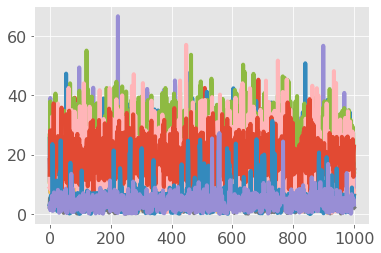

In [23]:
plt.plot(trace.get_values('b'));

In [24]:
trace.get_values('beta_1').shape

(1000, 10)

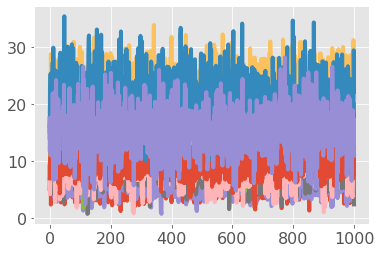

In [192]:
plt.plot(trace.get_values('noise_var'));

In [81]:
trace.get_values('b').shape

(1000, 4)

In [67]:
 betas

array([[ 3.86841970e+00,  1.36408638e-01,  1.05925620e-01],
       [ 5.24955963e+00,  1.34238323e-01,  4.20512519e-02],
       [ 4.51836681e+00,  3.34706599e-01,  7.23739341e-02],
       [ 6.07129699e+00, -1.20669762e-01, -2.58687689e-01],
       [ 4.21395212e+00, -8.79147702e-02,  5.20887389e-01],
       [ 3.58163711e+00,  1.93281027e-01,  3.90738448e-02],
       [ 3.75731422e+00, -5.45573938e-02,  8.72534511e-02],
       [ 7.49428675e+00,  6.94110099e-02,  1.19615912e-01],
       [ 5.19136044e+00,  3.38517604e-02, -8.81817902e-03],
       [ 3.06794914e+00,  2.30516416e-01,  3.01895054e-01],
       [ 5.24592659e+00, -1.48074983e-01,  4.86862695e-02],
       [ 3.21513986e+00,  7.75134684e-02,  2.10192724e-02],
       [ 4.48366486e+00,  1.47940438e-01,  2.58747400e-01],
       [ 5.60042246e+00,  2.86907367e-01, -1.28203832e-01],
       [ 4.82976375e+00,  1.85275984e-01,  7.95002605e-02],
       [ 2.51799318e+00,  1.09683741e-01,  3.30925530e-01],
       [ 5.17022926e+00, -3.30518147e-01

In [142]:
betas[0,:]

array([3.8684197 , 0.13640864, 0.10592562])

In [31]:
n_dept = len(X_depts)
with pm.Model() as marginal_gp_model:
    
    # priors
    sigma_squared_beta_0 = pm.InverseGamma('sigma_squared_beta_0', alpha=0.5, beta=.5) 
    sigma_squared_beta_1 = pm.InverseGamma('sigma_squared_beta_1', alpha=0.5, beta=.5)
    sigma_squared_beta_2 = pm.InverseGamma('sigma_squared_beta_2', alpha=0.5, beta=.5)
    mu_beta_0 = pm.Normal("mu_beta_0", mu=0.0, sigma=10)
    mu_beta_1 = pm.Normal("mu_beta_1", mu=0.0, sigma=10)
    mu_beta_2 = pm.Normal("mu_beta_2", mu=0.0, sigma=10)
    tau_s1 = pm.TruncatedNormal('tau_s1', mu=1, sigma=5, lower=0, shape=n_dept) 
    
    
    b_mean =  pm.Uniform(f"b_mean", lower=1, upper=300)
    b_std =  pm.Uniform(f"b_std", lower=0, upper=1)
    
    b = pm.TruncatedNormal("b", mu=b_mean, sigma=b_std, lower=0, shape=n_dept)
    beta_0_offset = pm.Normal(f"beta_0_offset", mu=0, sigma=1, shape=n_dept) 
    beta_0 = pm.Deterministic('beta_0', mu_beta_0 + np.sqrt(sigma_squared_beta_0)*beta_0_offset)
    beta_1_offset = pm.Normal(f"beta_1_offset", mu=0, sigma=1, shape=n_dept) 
    beta_1 = pm.Deterministic('beta_1', mu_beta_1 + np.sqrt(sigma_squared_beta_1)*beta_1_offset)
    beta_2_offset = pm.Normal(f"beta_2_offset", mu=0, sigma=1, shape=n_dept) 
    beta_2 = pm.Deterministic('beta_2', mu_beta_2 + np.sqrt(sigma_squared_beta_2)*beta_2_offset)
    
    means = [beta_0[i] + beta_1[i] * X_depts[i][:, 1] + beta_2[i] * X_depts[i][:, 2] for i in range(n_dept)]
    noise_var = pm.TruncatedNormal('noise_var', mu=1, sigma=5, lower=0, shape=n_dept) 
    K = [tau_s1[i] * tt.exp(-distance_mats[i]**2 / b[i]**2) + 1e-8 * tt.eye(len(distance_mats[i])) for i in range(n_dept)]      
    
   
    
    #bandwidth_sq = pm.Uniform('b', lower=0, upper=1e6, shape=n_dept)
    #bandwidth_sq = [50**2, 20**2, 30**2]#50**2
    #bandwidth_sq = 50**2
    #mu_b = pm.Uniform('mu_b', lower=0, upper=100) 
    #std_b = pm.Uniform('std_b', lower=0, upper=100) 
    #mu_s1 =  pm.Uniform('mu_s1', lower=0, upper=10) 
    #std_s1 =  pm.Uniform('std_s1', lower=0, upper=10) 
    #tau_s1_offset =  pm.Normal('tau_sq_offset', mu=0, sigma=1, shape=n_dept)
   # tau_s1 = pm.Deterministic('tau_s1', np.log(1+np.exp(mu_s1 + std_s1*tau_s1_offset))) 
    
    #mu_b =  pm.Uniform('mu_s1', lower=0, upper=10) 
    #std_b =  pm.Uniform('std_s1', lower=0, upper=10) 
    #b =  np.log(1+np.exp(mu_s1 + std_s1*pm.Normal('tau_sq', mu=0, sigma=1, shape=n_dept)))
   
    
    
    y_ = [pm.MvNormal(f'y{i}', mu=means[i], cov=K[i]+noise_var[i]*tt.eye(distance_mats[i].shape[0]), shape=len(y_depts[i]), observed=y[i]) for i in range(n_dept)]  
    

In [32]:
with marginal_gp_model:
    step=pm.Metropolis()
    trace = pm.sample(20, tune=50, chains=1)

WARNING (theano.tensor.opt): Optimization Warning: The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.

KeyboardInterrupt



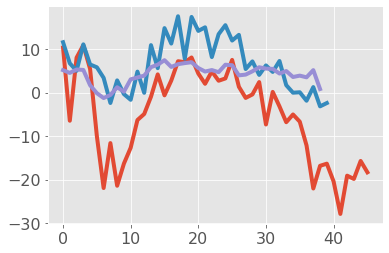

In [277]:
plt.plot(y[0])
plt.plot(y[1])
plt.plot(y[2])

In [321]:
(trace.get_values('noise_var')).mean(axis=0)

array([0.48993415, 0.45312309, 0.40096296, 0.88058948, 0.54661316,
       0.88577705, 1.06277134, 1.29315328, 0.62781837, 1.19735098,
       1.04572712, 0.91500406, 1.24387282, 1.09982319, 0.07445268])

In [327]:
trace.get_values('b_mean').shape

(20,)

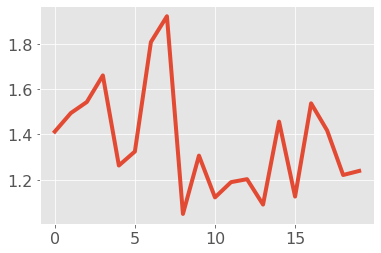

In [325]:
plt.plot(trace.get_values('b_mean'));
#plt.axhline(y=150**2)

In [291]:
150**2

22500

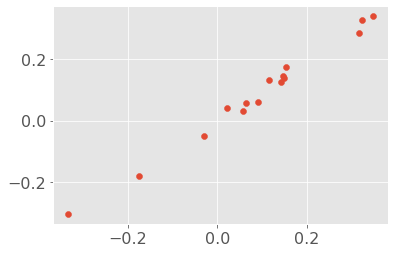

In [298]:
#plt.plot(trace.get_values('tau_sq')[:,2])
#plt.hist(trace.get_values('sigma_squared_beta_0'));
plt.scatter(trace.get_values('beta_2').mean(axis=0), betas[:,2][:n_dept]);
#plt.plot([4, 7], [4, 7])
#plt.hist(trace.get_values('sigma_squared_beta_2'));

In [299]:
trace.get_values('tau_s1').mean(axis=0)

array([0.41305695, 0.4960725 , 0.9942891 , 1.9495742 , 1.35050469,
       1.14839129, 2.11653103, 1.16084225, 0.69167497, 1.80563731,
       1.42769997, 0.90453411, 1.38176603, 0.66824439, 0.43593521])

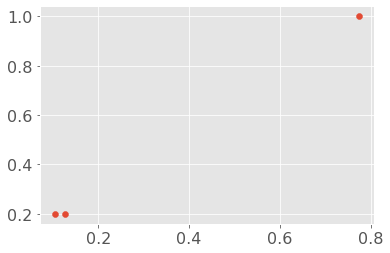

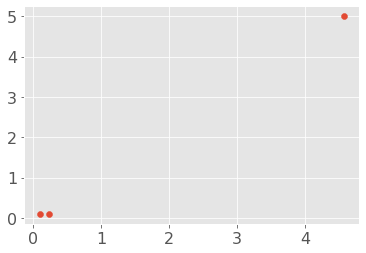

In [300]:
beta_std_model = [trace.get_values('sigma_squared_beta_0').mean(), trace.get_values('sigma_squared_beta_1').mean(), trace.get_values('sigma_squared_beta_2').mean()]
plt.scatter(beta_std_model, std_betas)
plt.figure()
beta_means = [trace.get_values('mu_beta_0').mean(), trace.get_values('mu_beta_1').mean(), trace.get_values('mu_beta_2').mean()]
plt.scatter(beta_means, mu_betas)


In [82]:
beta_means

[5.032575599930593, 0.06732780816433251, 0.14241944852393723]

In [83]:
mu_betas

[5, 0.1, 0.1]

In [2259]:
#plt.hist(trace.get_values('b')[:,2]);
#plt.hist(trace.get_values('mu_beta')[:,1], bins=100);
#plt.hist(trace.get_values('mu_beta')[:,2], bins=100);

#plt.hist(trace.get_values('beta')[:,0,2], bins=100);#plt.hist(trace.get_values('beta')[:,0,1], bins=100);
#plt.hist(trace.get_values('beta')[:,0,0], bins=100);
#plt.ylim(0,1000)
#plt.hist(trace.get_values('beta')[:,0,2], bins=100);

In [2266]:
az.plot_trace(trace, var_names='mu_beta_0');

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/juliette/opt/anaconda3/envs/reseach_env/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(

KeyboardInterrupt



In [24]:
with marginal_gp_model:
    ppc = pm.sample_posterior_predictive(
        trace
    )

ValueError: x and y must be the same size

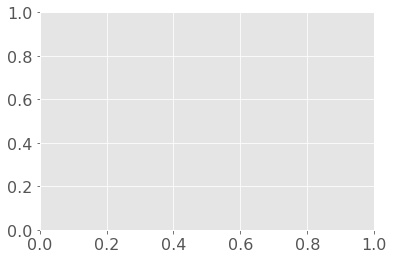

In [1837]:
plt.scatter(time_vecs[1], y[1])
plt.plot(time_vecs[1], X_depts[1]@trace.get_values('beta')[:,1].mean(axis=0))
#plt.plot(time_vecs[1], ppc['y'][0:60,:].T, color='dodgerblue', alpha=.05);